# k-Nearest Neighbours

Chapter 4.2 of https://course.elementsofai.com/ discussed the Nearest Neighbour (NN) classifier, where unclassified items are classified using the "nearest" known training-data-point's label. The k-NN classifier works very similarly; instead of using the single nearest known neighbour of an unknown datapoint, it uses the "k" nearest neighbours and takes the most common class among those neighbours. Basically, with $k = 1$ k-NN would do the exact same as the NN classifier, where k is the number of neighbours considered.

Consider the following example where the test sample (green dot) should be classified either to blue squares or to red triangles:

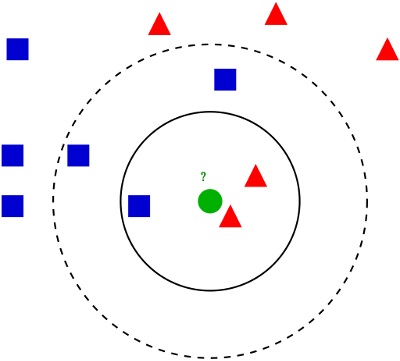

In the case of $k = 1$, k-NN would assign the test sample (green circle) to the class of red triangles, because the nearest other datapoint is a red triangle. If $k = 3$ (solid circle) it is assigned to the red triangles because there are 2 triangles and only 1 square inside the inner circle. If $k = 5$ (dashed circle) it is assigned to the blue squares (3 squares vs. 2 triangles inside the outer circle).

Like Nearest Neighbour, k-Nearest Neighbours is a classification algorithm, which will predict a classification for a new sample, based on data for which you already know the classification, i.e. the training data. Both classifiers can be used with the same type of data, k-NN just considers more neighbours when making its prediction (we'll dive a little more deeply into the exact effect of that later). For example, you might be classifying whether or not a new incoming bank transaction is fraudulent or not. You can compare this new transaction to other transactions you've seen in the past, based on attributes like the exact amount, country of origin, etc. and see which transactions were most similar. Then, using whether or not these similar transactions were in fact fraud or not, you can make a prediction for your new transfer.

For this notebook we'll go through building a k-NN classifier step by step.

## Nearest Neighbour

First we will get started with just finding the nearest neighbour. We will use the geometric distance (also known as straight-line distance, or Euclidean distance) to decide which is the nearest, most similar, item.

### Euclidean Distance

The Euclidean distance $d$ between point $p$ with coordinates $(p_x, p_y)$ and point $q$ with coordinates $(q_x, q_y)$ is defined as:

$$ dist(p,q) = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2} $$

This can be read as; the straight-line distance between $p$ and $q$ is equal to the square root of the sum of squared differences in the $x$ and $y$ dimension (which is still quite abstract).

To make this more clear, consider the following example:

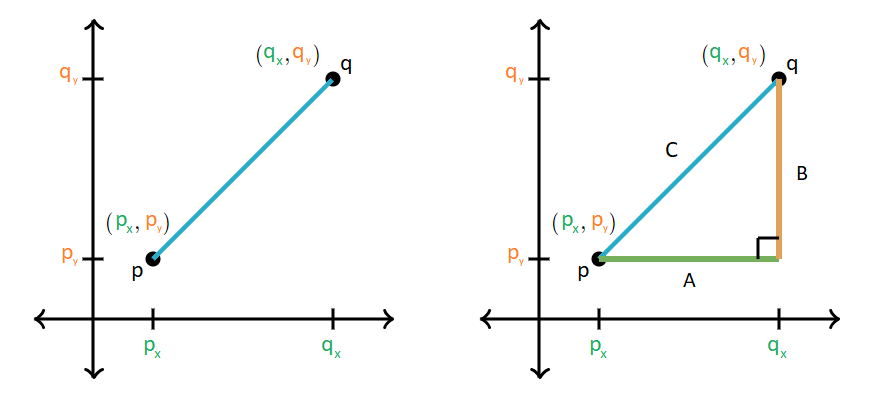

The Euclidean distance between point $p$ and $q$ is depicted as the blue line ($C$). As you can see, we can use the Pythagorean Theorem ($A^2 + B^2 = C^2$) to calculate the length of $C$. To do this, we first need the length of $A$ and $B$. The length of $A$ is equal to $(q_x - p_x)$, while the length of $B$ is equal to $(q_y - p_y)$. Now, applying the Pythagorean Theorem we end up with:

$$ C^2 = A^2 + B^2 $$

$$ C = \sqrt{A^2 + B^2} = \sqrt{(p_x - q_x)^2 + (p_y - q_y)^2} = d(p,q)$$

Each axis, so in this picture the $x$ and $y$ axes, corresponds to a *feature* in our data set, i.e. an attribute we can use to determine how similar a new sample is to other samples, and based on which we can then make our prediction. So, using the fraud example from before, the $x$-axis might correspond to the amount transferred as a part of the transaction (in euro's) and the $y$-axis might be the time-of-day (in seconds) the transaction was made. However, there might be many more features in our data set we want to consider than just these two, like for example the country code the transaction originated from, or even the exact bank account number.

The reason we use two features here, is that this is the easiest to plot by far and therefore we can also easily visualize what exactly the classifier has learned based on the training data. However, for many applications you'll want to be able to use more than just two features to determine the closest sample, as mentioned above. Therefore, you'd usually write numbered indices for your axes, instead of $x$ and $y$, as you'll run out of letters quite quickly. We could just define the $x$ dimension to be $1$ and $y$ dimensions to be $2$, and then we can rewrite our formula for the distance like this:

$$ dist(p,q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2} $$ 

Another nice thing about writing it this way, is that we can then also use the [Capital-sigma notation](https://en.wikipedia.org/wiki/Summation#Capital-sigma_notation) to write the *Euclidean distance* in a much more general way, so the equation works for any number of dimensions:

$$ dist(p,q) = \sqrt{\sum^d_{i=1}(p_i - q_i)^2} $$

Here $d$ is the number of dimensions, or axes, you want to determine the distance over. If we use $d=2$, then we get back the equation from before. However, we could now also use $7$ or $24$, or any other number of dimensions, as long as $d$ is some positive integer. Note, that this will become difficult to plot though, so we'll stick with $2$ for now.

### Assignment 1: Compute the distance

Complete the function `dist(p,q)` below. This function should compute the Euclidean distance between two coordinate-lists, `p` and `q`, and return the result. You may assume that `p` and `q` both are always 2-dimensional, i.e. $d=2$, so both `p` and `q` will always have a length of exactly $2$, with index $0$ corresponding to the $x$-axis value and index $1$ corresponding to the $y$-axis value. To determine the square root, you can use the [math.sqrt](https://docs.python.org/3.7/library/math.html#math.sqrt) function from the `math` library.

*Note:* Although the code does not need to work for any dimension other than $d=2$, it can be a nice challenge to try and write a more general `dist(p,q)` function that works for any value of $d$.


In [1]:
from notebook_checker import start_checks
# Start automatic globals checks
%start_checks

In [6]:
import math

def dist(p, q):
    # YOUR CODE HERE
    # this fits multi dimension for d>2
    s = 0
    for i in range(len(p)):
        s += (p[i] - q[i]) ** 2
    return math.sqrt(s)

a = [1, 2]
b = [3, 4]

distance = dist(a, b)
print(f'The distance between the points {a} and {b} is {distance:.4f}')

The distance between the points [1, 2] and [3, 4] is 2.8284


In [7]:
# Testing cell
assert abs(dist(a, b) - math.sqrt(8)) < 10**-10, 'Something is wrong in your calculation.';
print('Solution seems correct!')

Solution seems correct!


## Training data

Now that we can define the distance between two points, we can also find the closest neighbouring point of any given collection of coordinates. This can be done by looping over every available point one by one, and saving the point that is currently the closest and the current closest distance at every step.

Below is the data set we'll be using for the rest of this assignment. Each point is represented as a coordinate-list, where the first value corresponds to the $x$-axis and the second to the $y$-axis. The collection of all the points in this data set together, called `training_points`, is a *list of lists*. There are two possible classes for each point in the data set; $-1$ and $1$. Using the fraud detection example from before, $-1$ might correspond to the case where no fraud was found and $1$ to the case where fraud was actually detected.

The class for each of the `training_points` is stored in a separate list called `training_classes`. Each point in `training_points` has exactly one class, which is stored at the same index in `training_classes`. So, for example, the point at index $3$ is `[35, 20]` and if we want to know the class for that point, we should just look at that same index $3$ in the `training_classes` list, resulting in a class of $1$.

The function `plot_points()` has already been provided below. Read the code there and make sure you understand all the steps before moving on. Finally, run this code to see the actual plot of the data and inspect how the values in the training data are distributed.

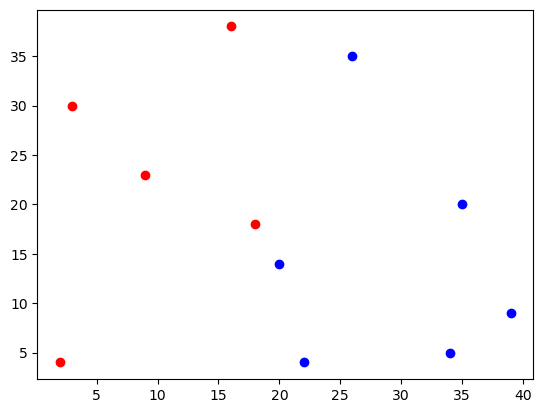

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt


# Training data
training_points = [[20, 14], [9, 23], [2, 4], [35, 20], [39, 9], [34, 5],
                   [18, 18], [22, 4], [3, 30], [26, 35], [16, 38]]

training_classes = [1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1]


def plot_points(points, classes):
    # Loop over all the indices i from 0 to the length of the points list
    for i in range(len(points)):
        
        # Get the i-th point and the i-th class from the lists
        point = points[i]
        point_class = classes[i]
        
        # Color points with class 1 blue
        point_color = 'blue'
        
        # Color points with class -1 red
        if point_class == -1:
            point_color = 'red' 
        
        # Plot each point using the x-value at position 0 and the y-value
        # at position 1. Plot the point with the correct color for its class.
        plt.scatter(x=point[0], y=point[1], color=point_color)

    plt.show()
    
plot_points(training_points, training_classes)

### Assignment 2: Finding the closest neighbour

Next, let's say that we now have a *new* point we want to classify, called `test_point`. In order to classify this point, we will first need to determine what the closest training point is. For now, you don't have to worry about also finding the correct class, but only finding which point is the closest to this `test_point`.

Complete the code below to find the nearest point to this `test_point` from the `training_points` list. You should reuse your `dist()` function from before to find the nearest point. Store the result in a variable called `nearest_point` and the distance to that point in a variable called `nearest_distance`. 

*Note:* Normally for this type of code, that is an operation we will reuse a lot later in the code, you would almost always write a function. However, for this assignment we recommend you just copy-and-paste this code when you need it again later. You can then modify this code as needed when you copy it to other assignments. We'll work on writing better code in other modules, but for now the simple copy-and-paste solution is fine.

In [9]:
# Our test point, to which we want to find the closest training point
test_point = [21, 25]

# Set current closest distance to something very far away
nearest_distance = math.inf
nearest_point = None

# Loop over the indices in the training_points list
for i in range(len(training_points)):
    point = training_points[i]
    
    # YOUR CODE HERE
    # compute distance
    d = dist(test_point, point)
    
    #check if its the closest pt
    if d < nearest_distance:
        nearest_distance = d
        nearest_point = point

#### Verifying your results

Below is a plot of the testing point and a cell that will test if your solution is correct. Make sure everything works correctly and you understand the results before moving on to the next assignment.

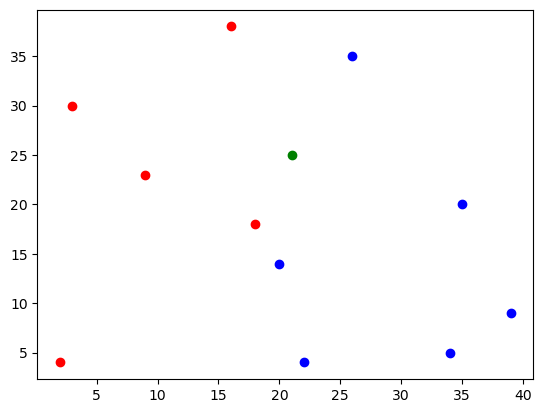

The closest training point to the test point is at [18, 18]


In [10]:
# Plot the test point in green
plt.scatter(x=test_point[0], y=test_point[1], color='green')

# Add the training points to the plot
plot_points(training_points, training_classes)

# Print the results
print(f'The closest training point to the test point is at {nearest_point}')


In [11]:
# Testing cell
assert abs(nearest_distance - math.sqrt(58)) < 10**-10, 'This is not the correct distance.'
assert nearest_point == [18, 18], 'This is not the closest point.'; print('Solution seems correct!')

Solution seems correct!


### Assignment 3: Nearest Neighbour classifier

In order to classify this test point, besides finding the closest neighbour in the training data, we'll also need to know the actual class of that closest neighbour point. If we can determine the class of the closest neighbour, then we've already built a complete *Nearest Neighbour* classifier!

Below is a function called `nearest_neighbour`, which should implement the nearest neighbour classifier. The arguments of the function are an unknown point `p`, a list of known `points` and a corresponding list of known `classes`. You should assume that the indices between the `points` and the `classes` match, i.e. that a point at a specific index $i$ in the `points` list, will have its class stored at that same index $i$ in the `classes` list. The function should return the `nearest_point_class`, which should contain the classification of the unknown point `p`, based on the nearest neighbour of the provided known points data.

*Note:* You can (and should!) copy part of your solution from the previous assignment to complete this function. There is an important difference though, as the code here is part of a function which takes the *function arguments* `points` and `classes`, whereas the code before used the *global variables* `training_points` and `training_classes` directly. You'll need to modify the code to work with the function arguments instead of these global variables. This way, if we want to use different training data to classify a new test point, we can just call the `nearest_neighbour` function using different `points` and `classes` lists, which makes our function much more reusable. In general, you should use function arguments and avoid using global variables whenever possible!


In [12]:
def nearest_neighbour(p, points, classes):
    # Set current closest distance to something very far away
    nearest_distance = math.inf
    nearest_point = None
    nearest_point_class = None
    
    # Loop over the indices in the points list
    for i in range(len(points)):
        
        # YOUR CODE HERE
        point = points[i]
        d = dist(p, point)
        
        if d < nearest_distance:
            nearest_distance = d
            nearest_point = point
            nearest_point_class = classes[i]
    
    return nearest_point_class


# Classify the test point based on the nearest neighbour
test_class = nearest_neighbour(test_point, training_points, training_classes)

print(f'The class of the closest training point to the test point is {test_class}')

The class of the closest training point to the test point is -1


In [13]:
# Testing cell
assert nearest_neighbour([11, 17], training_points, training_classes) == -1, 'Classification is incorrect!'
assert nearest_neighbour([35, 30], training_points, training_classes) == 1, 'Classification is incorrect!'
assert nearest_neighbour([10, 35], training_points, training_classes) == -1, 'Classification is incorrect!'

assert nearest_neighbour([30, 31], [[33, 45], [55, 60]], [5, 7]) == 5, 'Incorrect use of global variables!'
assert nearest_neighbour([57, 62], [[33, 45], [55, 60]], [5, 7]) == 7, 'Incorrect use of global variables!'
assert test_class == -1, 'Incorrect class for the test point.'; print('Solution seems correct!')

Solution seems correct!


### Visualizing the classification results

Next, let's try to visualize the correct nearest neighbour class for *any* possible test point when using this specific training data set. For this we can construct something called a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram), which partitions a surface into different regions, each consisting of all the points closest to one specific data point. This corresponds exactly to what a nearest neighbour classifier does, and so we can color the regions for the points with class $1$ blue and regions for the points with class $-1$ red. Now, using just the color in this diagram, we can very easily predict the class of any new test points:

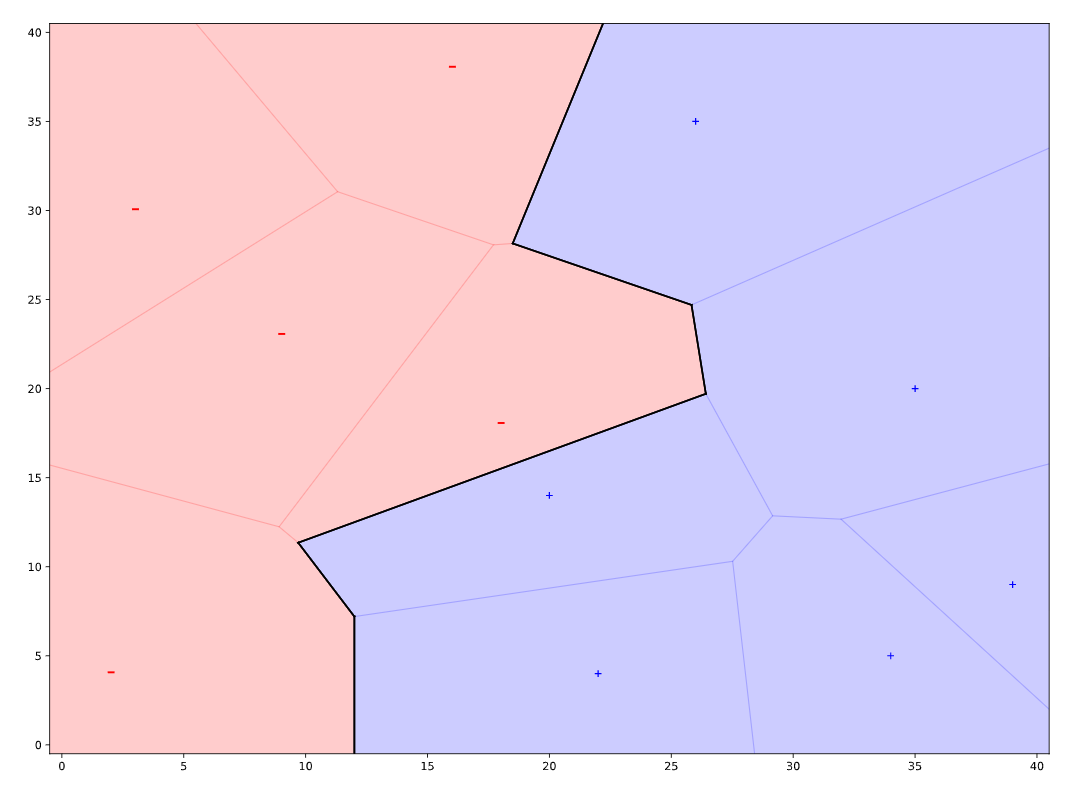

The black line in this image shows what is called the *Decision Boundary*, the border of the problem space where the predicted class switches from one class to the other. Any points that lie precisely on this Decision Boundary are *exactly* as close to the closest blue point, as to the closest red point. Any new point that falls exactly on the Decision boundary is ambiguous, as it is equally likely to be one class or the other, so then usually a random classification is made to break the tie.

### Assignment 4: Approximating the class distribution by sampling the nearest neighbours

Constructing an exact Voronoi diagram from the data set can be quite complex, but we can also make an approximation by sampling a lot of points in the plot and determining the nearest neighbours for each of them. Below is some code to already get you started, which will loop over all $x$ and $y$ coordinates and construct these sample points. Complete this code to correctly fill the `sample_points` lists and `sample_classes` lists with each of the corresponding classifications. You should use your `nearest_neighbour()` function from the previous assignment to determine the classification of each sample point.

The resulting plot of all these sample point classifications should look like a coarse approximation of the image above. Make sure you understand why these two plots are similar before moving on to the next section.


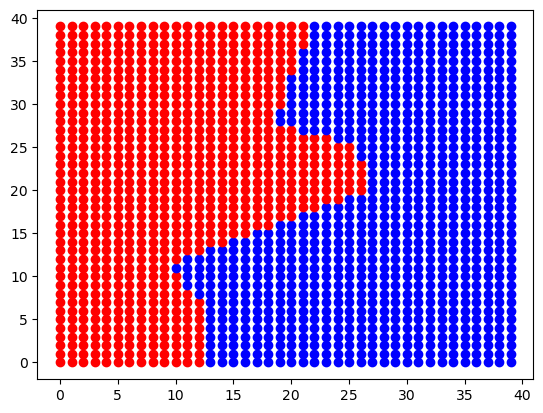

In [15]:
# Range of samples to take in the x and y direction
N = 40

# These lists will be filled with all the sample points and their classifications
sample_points = []
sample_classes = []

# Loop over all x and y coordinates
for x in range(N):
    for y in range(N):
        # Construct the new sample point
        point = [x, y]
        
        # YOUR CODE HERE
        clas = nearest_neighbour(point, training_points, training_classes)
        sample_points.append(point)
        sample_classes.append(clas)


# Create the plot with the sample classifications
plot_points(sample_points, sample_classes)

## k-Nearest Neighbours

Now that we have a complete method of finding the Nearest Neighbour, the step to finding the $k$-Nearest Neighbours is actually quite small. We can just repeat our finding the nearest neighbour $k$ times, while ignoring any neighbour point that we have already found.

#### The `in` keyword

There are several methods that you can use to ignore points that you have already determined were the closest before. The simplest method is probably using the Python keyword `in` together with an `if`statement, which can be used to check *if* an element occurs *in* a list or not.

Below is a quick example of using `in` this way. Make sure you understand it before moving on to the next step.

*Note:* This use of `in` is different from the `in` used together with a `for`loop, which is used to loop over the elements *in* a list.

In [16]:
example_list = [[10, 12], [13, 4], [20, 5]]

for point in [[20, 5], [30, 3]]:
    
    point_present = point in example_list
    print(f'\nThe point {point} is in the list {example_list} : {point_present}')
    
    # Check if the point occurs in the list
    if point in example_list:
        print('The point was found!')
    
    # This line could (and probably should!) be an `else` instead, of course 
    # However, this line is here only to demonstrate this type of `not` check
    if point not in example_list:
        print('The point was not found.')


The point [20, 5] is in the list [[10, 12], [13, 4], [20, 5]] : True
The point was found!

The point [30, 3] is in the list [[10, 12], [13, 4], [20, 5]] : False
The point was not found.


### Assignment 5: Finding the k-Nearest Neighbours

Complete the code below to find all of the $k$-Nearest Neighbours to the `test_point` from before. For this you should reuse your code from the `nearest_neighbour()` function earlier and copy the contents here.

You'll need to repeat finding the nearest neighbour for each of the $k$-nearest you want to find, but your code should, of course, find a *different* neighbour each time. This means you'll need to build the list of neighbours as you go, and then only check the *remaining* points to find the next nearest point. So, before checking if a point is closer, you should also check if it was not a nearest neighbour before! To do this, you'll need to make a few modifications:

1. After you've completed a single loop to find a new nearest neighbour, add that neighbour to the `neighbour_points` list and add its class to the `neighbours_classes` list.
2. When searching for a nearest neighbour, make sure each point you're comparing was not already a nearest neighbour before. You can use the `in` keyword for to check for this, as shown above.
3. As this piece of code is not inside any function, you'll have to temporarily switch back to using the global variables `training_points`, `training_classes` and `test_point` directly.

*Optional:* The solution presented here is pretty inefficient, as you're recomputing the distance to every point every single time. If you have a bit of programming experience and would like more of a challenge, try to find an efficient way to determine the $k$-Nearest Neighbours, that doesn't require recomputing the distances at every step.


In [19]:
# Number of neighbours to consider
k = 3

# Maintain a list of nearest neighbours already found
neighbours_points = []

# And the classes associated with each of these neighbours
neighbours_classes = []


# Repeat for each of the nearest neighbours
for k_count in range(k):
    
    # Set current closest distance to something very far away
    nearest_distance = math.inf
    nearest_point = None
    nearest_point_class = None

    # YOUR CODE HERE
    for i in range(len(training_points)):
        point = training_points[i]

        # skip if alr in neighbours
        if point in neighbours_points:
            continue

        d = dist(test_point, point)
        if d < nearest_distance:
            nearest_distance = d
            nearest_point = point
            nearest_point_class = training_classes[i]

    neighbours_points.append(nearest_point)
    neighbours_classes.append(nearest_point_class)

    
print(f'The {k} nearest neighbours to the test point are {neighbours_points}')
print(f'And the classes of these {k} neighbours are {neighbours_classes}')

The 3 nearest neighbours to the test point are [[18, 18], [20, 14], [26, 35]]
And the classes of these 3 neighbours are [-1, 1, 1]


In [25]:
# optional challenge

k = 3

# make a list of (distance, index)
dists = []
for i in range(len(training_points)):
    d = dist(test_point, training_points[i])
    dists.append((d, i))

# sort by distance(by default, so no need define key)
dists.sort()

# take the first k element
neighbours_points = []
neighbours_classes = []
for j in range(k):
    index = dists[j][1]
    neighbours_points.append(training_points[index])
    neighbours_classes.append(training_classes[index])

print(f'The {k} nearest neighbours to the test point are {neighbours_points}')
print(f'And the classes of these {k} neighbours are {neighbours_classes}')

The 3 nearest neighbours to the test point are [[18, 18], [20, 14], [26, 35]]
And the classes of these 3 neighbours are [-1, 1, 1]


In [26]:
# Testing cell
assert neighbours_points == [[18, 18], [20, 14], [26, 35]], 'You have not found the correct neighbours.';
print('Solution seems correct!')

Solution seems correct!


### Assignment 6: Determining the predicted class.

Next we'll need to add code to determine the class of an unknown datapoint. In k-NN this is done by taking the most common class among the k-Nearest Neighbours. Since we have defined our two possible class-values as $-1$ and $1$, this can easily be done by just taking the sum of the class labels of the nearest neighbours of the test point, and seeing if this value is negative, positive, or zero.

When the value of this sum is positive, then there were more points with the class $1$, than there were points with the class $-1$. Conversely, when the value of this sum is negative, there were more points with the class $-1$. If the sum is exactly $0$, then there was an equal number of both classes and you may classify these points as always belonging to class $1$ or always belonging to class $-1$, your choice.

Write some code below that loops over the `neighbours_classes` list from the previous assignment and sums all the class labels together. Then, based on this sum, determine the predicted classification for the `test_point` and store this classification in the variable `predicted_class`.

In [27]:
predicted_class = 0

# YOUR CODE HERE
# take sum here
s = 0
for c in neighbours_classes:
    s += c

if s > 0:
    predicted_class = 1
elif s < 0:
    predicted_class = -1
else:
    predicted_class = 1   # i choose 1 by default

print(f'The predicted class for the test point is {predicted_class}.')

The predicted class for the test point is 1.


In [28]:
# Testing cell
assert predicted_class == 1, 'The predicted class is incorrect.'; print('Solution seems correct!')

Solution seems correct!


### Assignment 7: Building a k-Nearest Neighbour classifier

Finally, we just need to combine these last two steps into a single `knn()` function.

The arguments of this function will be an unknown point `p`, a list of known `points`, a corresponding list of known `classes`, and the number of neighbours to consider `k`. This function should only depend on these *function arguments*, so any references to global variables will have to be changed back to the function arguments. 

The function should return the `predicted_class`, which should contain the classification of the unknown point `p`, based on the `k` nearest neighbours among the provided known `points` and their respective `classes`.


In [29]:

def knn(p, points, classes, k):
    predicted_class = 0
    
    # Maintain a list of nearest neighbours already found
    neighbours_points = []

    # And the classes associated with each of these neighbours
    neighbours_classes = []

    # YOUR CODE HERE
    # i did not use the optional challenge here
    for k_count in range(k):
        nearest_distance = math.inf
        nearest_point = None
        nearest_point_class = None
        
        for i in range(len(points)):
            point = points[i]
            
            # skip if already chosen as neighbour
            if point in neighbours_points:
                continue
            
            d = dist(p, point)
            if d < nearest_distance:
                nearest_distance = d
                nearest_point = point
                nearest_point_class = classes[i]
        
        neighbours_points.append(nearest_point)
        neighbours_classes.append(nearest_point_class)
    
    # take sum here
    s = 0
    for c in neighbours_classes:
        s += c

    if s > 0:
        predicted_class = 1
    elif s < 0:
        predicted_class = -1
    else:
        predicted_class = 1   # i choose 1 by default
        
    return predicted_class


test_class = knn(test_point, training_points, training_classes, k)

print(f'Based on {k} neighbours the point {test_point} belongs to class {test_class}.')

Based on 3 neighbours the point [21, 25] belongs to class 1.


In [30]:
# Testing cell
assert knn(test_point, training_points, training_classes, 3) == 1, "Incorrect classification"
assert knn(test_point, training_points, training_classes, 5) == -1, "Doesn't work correctly with larger k"
assert knn(test_point, training_points, training_classes, 9) == 1, "Doesn't work correctly with larger k"

assert knn([20, 10], training_points, training_classes, 3) == 1, "Doesn't work correctly with new points"
assert knn([10, 30], training_points, training_classes, 3) == -1, "Doesn't work correctly with new points"

assert knn([30, 31], [[33, 45], [55, 60]], [1, -1], 1) == 1, 'Incorrect use of global variables in knn'
assert knn([57, 62], [[33, 45], [55, 60]], [1, -1], 1) == -1, 'Incorrect use of global variables in knn'
assert test_class == 1, 'The test point was classified incorrectly.'; print('Solution seems correct!')

Solution seems correct!


### Assignment 8: Visualising k-NN

Often, when exploring a data set or when you’re evaluating some algorithm, creating insightful visualizations of the data can be a very useful part of the process. Interactive data visualization can allow you to change parts of how the algorithm behaves and in some cases, this might lead to a greater understanding of the results than just a static visualization.

Below, we have provided you with some code to create an interactive version of the earlier nearest neighbours plot using `ipywidgets`. Complete this function to correctly fill the `sample_points` lists and `sample_classes` lists with each `point` classifications based on the `k` nearest neighbours. You should of course use your `knn()` function from the previous assignment to determine the classification of each sample point.

*Note:* There might be quite a delay before you see this graph. This is caused by the many times the k-NN algorithm must be run, once for each single dot in the graph. When you use the slider to change the value of $k$ in the plot, you'll therefore need to be a bit patient before you'll see the results.

In [31]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

def plot_knn(k, points, classes): 
    # Range of samples to take in the x and y direction
    N = 40

    # These lists will be filled with all the sample points and their classifications
    sample_points = []
    sample_classes = []

    # Loop over all x and y coordinates
    for x in range(N):
        for y in range(N):
            # Construct the new sample point
            sample = [x, y]
            
            # YOUR CODE HERE
            clas = knn(sample, points, classes, k)
            sample_points.append(sample)
            sample_classes.append(clas)

    plot_points(sample_points, sample_classes)


# Enable the interactive plot with slider
interact(plot_knn, k=widgets.IntSlider(value=1, min=1, max=11, step=2, continuous_update=False),
         points=fixed(training_points), classes=fixed(training_classes));

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', max=11, min=1, step=2), Out…

## Questions

Answer the following questions about this assignment. Write your answers in this cell, below each of the questions.


**Q1. So far, in this notebook, we have only used uneven values for $k$. What potential problem might occur when we use an even $k$? E.g. $k=2$, $k=4$, $k=6$, etc.**

then there might be a 'draw' case, like k=4, and in the 4 closest neighbours, 2 with class 1 , 2 with class -1,making the KNN unable to decide which class to assign the test point to. 

**Q2. What seems to happen to the classifications when $k=11$? Why does this happen?**

I have only 11 training datapoint here, so if i set k=11, then for every test datapoint, the knn counts all the 11 train datapoints, meaning it will always produce the same classification result. in this case, -1. This is a severe underfitting.

**Q3. What is the tradeoff you are making when you increase the value of $k$?**

increase k reduce the impact of noises and outliers, reduce variance, reduce overfitting. but it will increase bias and ignore some of the normal patterns, causing underfitting

**Q4. When would you want to use a small value for k and when would you use a larger value for k?**

I will use a small value, if the pattern is complex and when the decision boundary is complex, and when the dataset is large with few outliers. And when I want to observe more local patterns.

On the contrary, I will use a big value if the dataset is dirty and with many outliers, and I want a more smooth decision boundary, to make a general decision.